In [1]:
import pandas as pd

### Import Data

In [2]:
# Load Data
aapl = pd.read_csv('../data/aapl_concise.csv', index_col='Unnamed: 0')

In [3]:
aapl.head()

,shares_outstanding,earning_per_share,dividend_rate,dividend_yield,debt_to_equity,book_value_per_share,return_on_equity,current_ratio
2010-09,"6,473",2.16,NaN,NaN,NaN,7.45,35.28,2.01
2011-09,"6,557",3.95,NaN,NaN,NaN,11.78,41.67,1.61
2012-09,"6,617",6.31,0.38,NaN,NaN,16.99,42.84,1.50
2013-09,"6,522",5.68,1.63,27.4,0.14,19.60,30.64,1.68
2014-09,"6,123",6.45,1.81,28.5,0.26,20.62,33.61,1.08


### Calculate Intrinsic Value (Simple way)

##### (1) Estimate future dividends

In [4]:
# Last 10-year's average dividends
dvd_avg = aapl['dividend_rate'].mean()
print(dvd_avg)

2.1222222222222222


In [5]:
risk_free_rate = 0.0179
# The discounted capital for the dividend of 3-year later
dvd_avg/(1+risk_free_rate)**3
# The discounted capital for the dividend of 10-year later
# dvd_avg/(1+risk_free_rate)**10

2.0122202476874578

In [6]:
dvd_total = 0
for i in range(1,11):
    dvd_total = dvd_total + dvd_avg/(1+risk_free_rate)**i
print(dvd_total)

19.27420500514451


##### (2) Estimate future book value

In [7]:
# Average growth rate
book_value = aapl['book_value_per_share']

In [8]:
# 9th root
book_value = aapl['book_value_per_share']
growth_rate_of_9y= book_value['2019-09']/book_value['2010-09']
avg_growth_rate = growth_rate_of_9y**(1/9)
print(avg_growth_rate)

1.1261895823169403


In [10]:
# Book value per share in next 10 years
bvps_pred = book_value['2019-09']*(avg_growth_rate**10)
print(bvps_pred)

71.24836125032327


##### (3) Combine 2 parts

In [11]:
aapl_intrinsic = bvps_pred + dvd_total
print(aapl_intrinsic)

90.52256625546778


In [12]:
# ignore TTM for now
aapl = aapl.drop(aapl.tail(1).index)

<AxesSubplot:title={'center':"Apple's Dividends in Last 10 Years"}>

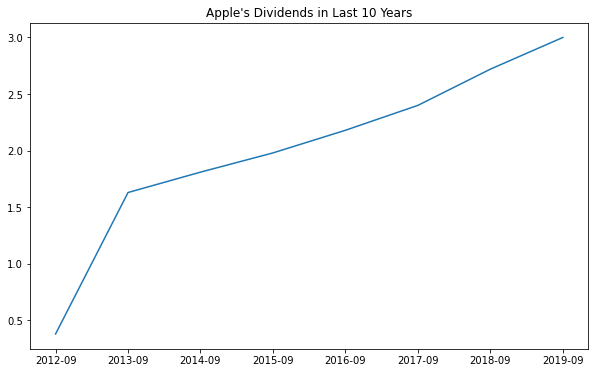

In [13]:
aapl['dividend_rate'].plot(figsize=(10,6), title="Apple's Dividends in Last 10 Years")

<AxesSubplot:title={'center':"Apple's Book Value in Last 10 Years"}>

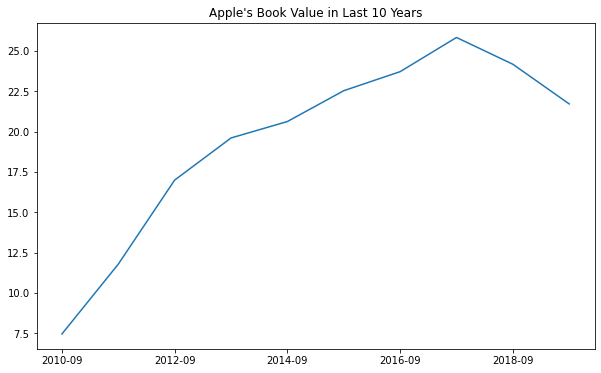

In [14]:
aapl['book_value_per_share'].plot(figsize=(10,6), title="Apple's Book Value in Last 10 Years")

### Calculate Intrinsic Value using Linear Regression

In [16]:
import statsmodels.api as sm

##### (1) House Keeping

In [17]:
# 'year_index' as the order of the year
aapl['year_index'] = range(1, len(aapl) + 1)
# add intercept
aapl['intercept'] = 1

##### (2) Book Value per Share

In [18]:
# modeling
bvps_model = sm.OLS(aapl['book_value_per_share'], aapl[['year_index','intercept']]).fit()

In [19]:
bvps_pred_lr = bvps_model.predict([19,1])[0]
print(bvps_pred_lr)

41.81709090909092


##### (3) Dividends

In [20]:
aapl_new = aapl.dropna(subset = ['dividend_rate'])

In [21]:
# modeling
dvd_model = sm.OLS(aapl_new['dividend_rate'], aapl_new[['year_index','intercept']]).fit()

In [22]:
# predict future dvd
dvd_model.predict([19,1])[0]

5.845833333333332

In [23]:
dvd_total_lr = 0
current_year_order = 9
for i in range(1,11):
    dvd_new = dvd_model.predict([current_year_order + i,1])[0]
    dvd_total_lr = dvd_total_lr + dvd_new/(1+risk_free_rate)**i
print(dvd_total_lr)

40.15163616617433


In [24]:
aapl_intrinsic_lr = dvd_total_lr + bvps_pred_lr
print(aapl_intrinsic_lr)

81.96872707526525
